In [99]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random as rand
import xarray as xr

from glob import glob
from matplotlib import colormaps, colors
# from pysteps.utils import rapsd
from numpy.fft import fftn
warnings.filterwarnings("ignore")

In [6]:
model = torch.jit.load("/sapho/rpayne/comet_output/generator_FWI-2025-Oct29-fwi-bs32.pt").cuda()

base_path = f"/home/rpayne/data-rpayne/proc/WRF-USASK/cint/"
covariate_names = [  # Make sure these are in the same order as given in the ClimatExML config file
    "tas", "uas", "vas", "psfc", "q2", "pr", "fwi",
]
predictand_names = [
    "fwi",
]
split = "test"
# subset_idxs = [2904, 5856] # Only select May 1 to Aug 31
subset_idxs = [5000, 5100]  # Use all data

# Topography data

path_topography_lr = os.path.join(base_path, f"invariant/topography/lr_invariant/topography.pt")
path_topography_hr = os.path.join(base_path, f"invariant/topography/hr_invariant/topography.pt")
topography_lr = torch.load(path_topography_lr).float().unsqueeze(0).unsqueeze(0)
topography_hr = torch.load(path_topography_hr).float().unsqueeze(0).unsqueeze(0)

print(topography_lr.shape, topography_hr.shape)

torch.Size([1, 1, 16, 16]) torch.Size([1, 1, 128, 128])


In [9]:
# Get PATHS to data (not the actual data yet)

covariate_paths, groundtruth_paths = {}, {}
if subset_idxs:
    i0, i1 = subset_idxs
    N_samples = i1 - i0
else:
    N_samples = len(glob(os.path.join(base_path, f"{split}/{covariate_names[0]}/lr/*.pt")))

path_topography_lr = os.path.join(base_path, f"invariant/topography/lr_invariant/topography.pt")
path_topography_hr = os.path.join(base_path, f"invariant/topography/hr_invariant/topography.pt")

for name in covariate_names:
    covariate_paths[name] = sorted(glob(os.path.join(base_path, f"{split}/{name}/lr/*.pt")))[i0:i1]
for name in predictand_names:
    groundtruth_paths[name] = sorted(glob(os.path.join(base_path, f"{split}/{name}/hr/*.pt")))[i0:i1]

In [4]:
# Load data from paths

covariate_data, groundtruth_data = {}, {}

topography_lr = torch.load(path_topography_lr).float().unsqueeze(0).unsqueeze(0)
topography_hr = torch.load(path_topography_hr).float().unsqueeze(0).unsqueeze(0)

for name in covariate_names:
    covariate_data[name] = [torch.load(file).float().unsqueeze(0).unsqueeze(0) for file in covariate_paths[name]]
for name in predictand_names:
    groundtruth_data[name] = [torch.load(file).float().unsqueeze(0).unsqueeze(0) for file in groundtruth_paths[name]]

In [27]:
# Get non-feature scaled max and min for each field (required for undoing feature scaling)

covariate_data_min_max, groundtruth_data_min_max = {}, {}

with open(os.path.join(base_path, "topography_lr_invariant.zarr/zarr.json"), 'r') as metadata_file:
    metadata = json.load(metadata_file)
    topography_lr_min = metadata["consolidated_metadata"]["metadata"]["topography"]["attributes"]["min"]
    topography_lr_max = metadata["consolidated_metadata"]["metadata"]["topography"]["attributes"]["max"]

with open(os.path.join(base_path, "topography_hr_invariant.zarr/zarr.json"), 'r') as metadata_file:
    metadata = json.load(metadata_file)
    topography_hr_min = metadata["consolidated_metadata"]["metadata"]["topography"]["attributes"]["min"]
    topography_hr_max = metadata["consolidated_metadata"]["metadata"]["topography"]["attributes"]["max"]

for name in covariate_names:
    with open(os.path.join(base_path, f"{name}_{split}_lr.zarr/zarr.json"), 'r') as metadata_file:
        metadata = json.load(metadata_file)
        data_min = metadata["consolidated_metadata"]["metadata"][name]["attributes"]["min"]
        data_max = metadata["consolidated_metadata"]["metadata"][name]["attributes"]["max"]
        covariate_data_min_max[name] = {"min": data_min, "max": data_max}
for name in predictand_names:
    with open(os.path.join(base_path, f"{name}_{split}_hr.zarr/zarr.json"), 'r') as metadata_file:
        metadata = json.load(metadata_file)
        data_min = metadata["consolidated_metadata"]["metadata"][name]["attributes"]["min"]
        data_max = metadata["consolidated_metadata"]["metadata"][name]["attributes"]["max"]
        groundtruth_data_min_max[name] = {"min": data_min, "max": data_max}

In [13]:
# Apply the model to downscale

downscaled_data = {}
input_tensor_hr = topography_hr.cuda()

for i in range(N_samples):
    
    # Prepare input tensor
    input_tensors_lr = [covariate_data[name][i] for name in covariate_names]
    input_tensor_lr = torch.cat(input_tensors_lr + [topography_lr], dim=1).cuda()  # Concatenate along channel dimension

    # Apply model
    with torch.no_grad():
        output_tensor = model(input_tensor_lr, input_tensor_hr)

    # Store output
    for j, name in enumerate(predictand_names):
        if name not in downscaled_data:
            downscaled_data[name] = []
        downscaled_data[name].append(output_tensor[:, j:j+1, :, :].cpu())

print(len(downscaled_data[predictand_names[0]]), "fields downscaled to size", downscaled_data[predictand_names[0]][0].shape)

100 fields downscaled to size torch.Size([1, 1, 128, 128])


# Plotting and Analysis

Generate 3 realizations and plot them alongside their mean and ground truth

In [173]:
def undo_feature_scaling(tensor, data_min, data_max):
    """Undo feature scaling to get back to original data range."""
    return tensor * (data_max - data_min) + data_min

def generate_realization(var, time_idx, seed=None):
    """Generate 1 super-resolved realization for a given variable at a specific time index."""
    if seed:
        torch.manual_seed(seed)
        np.random.seed(seed)
        rand.seed(seed)
    
    var_idx = predictand_names.index(var)
    datetime_str = os.path.basename(groundtruth_paths[var][time_idx]).split('_')[-1].replace('.pt', '')
    
    input_tensors_lr = [covariate_data[name][time_idx] for name in covariate_names]
    input_tensor_lr = torch.cat(input_tensors_lr + [topography_lr], dim=1).cuda()  # Concatenate along channel dimension
    with torch.no_grad():
        output_tensor = model(input_tensor_lr, input_tensor_hr)
        downscaled_field = output_tensor[:, var_idx:var_idx+1, :, :].cpu().squeeze()
    
    return (downscaled_field, datetime_str)

# Spectrum stuff

def power_spectrum(x):
    x_fft = torch.fft.fftn(x, norm='ortho')
    energy = torch.abs(x_fft).pow(2)
    return energy

def wave_number_radial(dim, d=1.0):
    freq = torch.fft.fftfreq(dim, d=d)
    grid_h, grid_w = torch.meshgrid(freq, freq, indexing="ij")  # must be 'ij'
    wave_radial = torch.sqrt(grid_h.pow(2) + grid_w.pow(2))
    return wave_radial

def rapsd(x, d=1.0):
    """
    Compute the radially averaged power spectral density (RAPSD) of a 2D square field.

    The RAPSD describes how the variance (energy) of a spatial field is distributed
    across spatial frequencies (wavenumbers), averaged over all directions. It is
    particularly useful in analyzing the spatial structure or scaling behavior of
    geophysical, meteorological, or image data.

    Parameters
    ----------
    x : torch.Tensor
        A 2D square tensor representing the spatial field (e.g., an image or gridded data).
        Must have shape (N, N).
    d : float, optional
        The grid spacing or physical distance between adjacent grid points.
        Defaults to 1.0.

    Returns
    -------
    bin_avgs : torch.Tensor
        The average power spectral density within each radial wavenumber bin.
    bins_mids : torch.Tensor
        The midpoints of the radial wavenumber bins.
    bin_counts : torch.Tensor
        The number of Fourier components contributing to each radial bin.

    Notes
    -----
    - The function computes the 2D Fourier transform of the input, converts it
      to an energy spectrum (squared magnitude), and bins it radially based on
      isotropic wavenumber magnitude.
    - The result provides a one-dimensional representation of the power spectrum,
      where `bins_mids` correspond to the isotropic wavenumber and `bin_avgs`
      gives the corresponding average spectral power.
    """

    if not (x.dim() == 2 and x.shape[0] == x.shape[1]):
        raise ValueError("Input x must be a square 2D tensor")

    dim = x.shape[0]
    wavenumber = wave_number_radial(dim, d=d)

    delta = wavenumber[0][1]
    freq_max = 1 / (2 * d)

    bins_edges = torch.arange(delta / 2, freq_max + delta / 2, delta)
    bins_edges = torch.cat((torch.tensor([0.0]), bins_edges))
    bins_mids = 0.5 * (bins_edges[1:] + bins_edges[:-1])
    bin_counts, _ = torch.histogram(wavenumber, bins=bins_edges)

    energy = power_spectrum(x)
    bin_sums, _ = torch.histogram(wavenumber, bins=bins_edges, weight=energy)
    bin_avgs = bin_sums / bin_counts

    return bin_avgs, bins_mids, bin_counts
    

In [151]:
# Select variable and (time-)index of field to plot
var = 'fwi'
var_idx = predictand_names.index(var)
subset_idx = 0
datetime_str = os.path.basename(groundtruth_paths[var][subset_idx]).split('_')[-1].replace('.pt', '')
N = 4 # number of realizations to produce

# Get min and max for undoing feature scaling
gt_min, gt_max = groundtruth_data_min_max[var]['min'], groundtruth_data_min_max[var]['max']

# Downscale N_realizations times
realizations = []
for i in range(N):
    realization = generate_realization(var, subset_idx, seed=i)[0]
    realization = undo_feature_scaling(realization, gt_min, gt_max)
    realizations.append(realization)

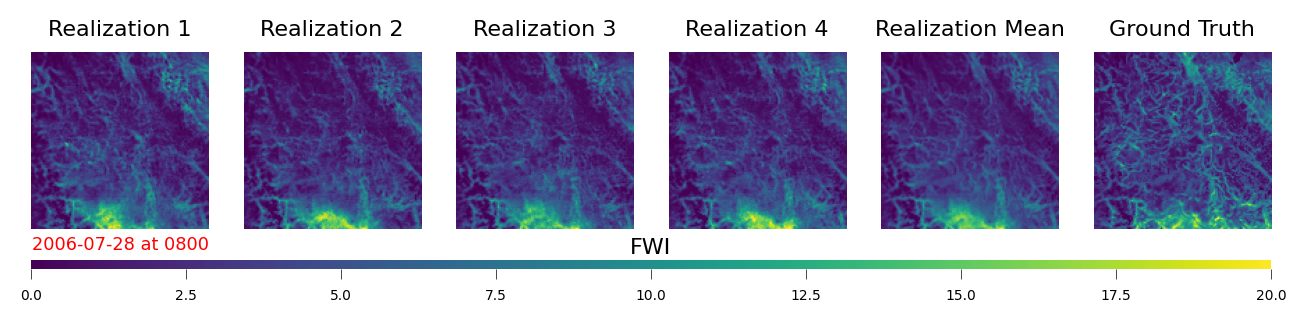

In [152]:
# ====================
# Plot realizations
# ====================
fig, ax = plt.subplots(nrows=1, ncols=N+2, figsize=(8,4), dpi=200)

# Figure constants
ts = 8
vmin = 0
vmax = 20
cmap = 'viridis'

# Plot the individual realizations
for i in range(N):
    realization = realizations[i]
    ax[i].imshow(realization, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    ax[i].set_title(f"Realization {i+1}", fontsize=ts)
    ax[i].axis('off')

# Plot the realization mean
realization_mean = (1/N)*sum(realizations)
ax[N].imshow(realization_mean, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
ax[N].set_title("Realization Mean", fontsize=ts)
ax[N].axis('off')

# Plot the ground truth
ground_truth = undo_feature_scaling(groundtruth_data[name][subset_idx].squeeze(), gt_min, gt_max)
refplot = ax[N+1].imshow(ground_truth, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
ax[N+1].set_title("Ground Truth", fontsize=ts)
ax[N+1].axis('off')

# Add datetime annotation... (11,3) for bottom right, (11,30) for top right
ax[0].text(0, -5, f'{datetime_str[:10]} at {datetime_str[11:]}00', fontsize=.8*ts, color='red', verticalalignment='top', horizontalalignment='left')

# Add colorbar (using the last plotted image for the colorbar)
colorbar = fig.colorbar(refplot, ax=ax, orientation='horizontal', pad=0.05, aspect=140)
colorbar.outline.set_visible(False)
colorbar.ax.tick_params(labelsize=5, width=.25)
colorbar.ax.set_title(f"{var.upper()}",fontsize=ts, pad=2.5)

plt.show()

In [212]:
# Select variable and (time-)index of field to plot
var = 'fwi'
var_idx = predictand_names.index(var)
subset_idx = 0
datetime_str = os.path.basename(groundtruth_paths[var][subset_idx]).split('_')[-1].replace('.pt', '')
N = 30 # number of realizations to produce

# Get min and max for undoing feature scaling
gt_min, gt_max = groundtruth_data_min_max[var]['min'], groundtruth_data_min_max[var]['max']

# Downscale N_realizations times
realizations = []
for i in range(N):
    realization = generate_realization(var, subset_idx, seed=i)[0]
    realization = undo_feature_scaling(realization, gt_min, gt_max)
    realizations.append(realization)

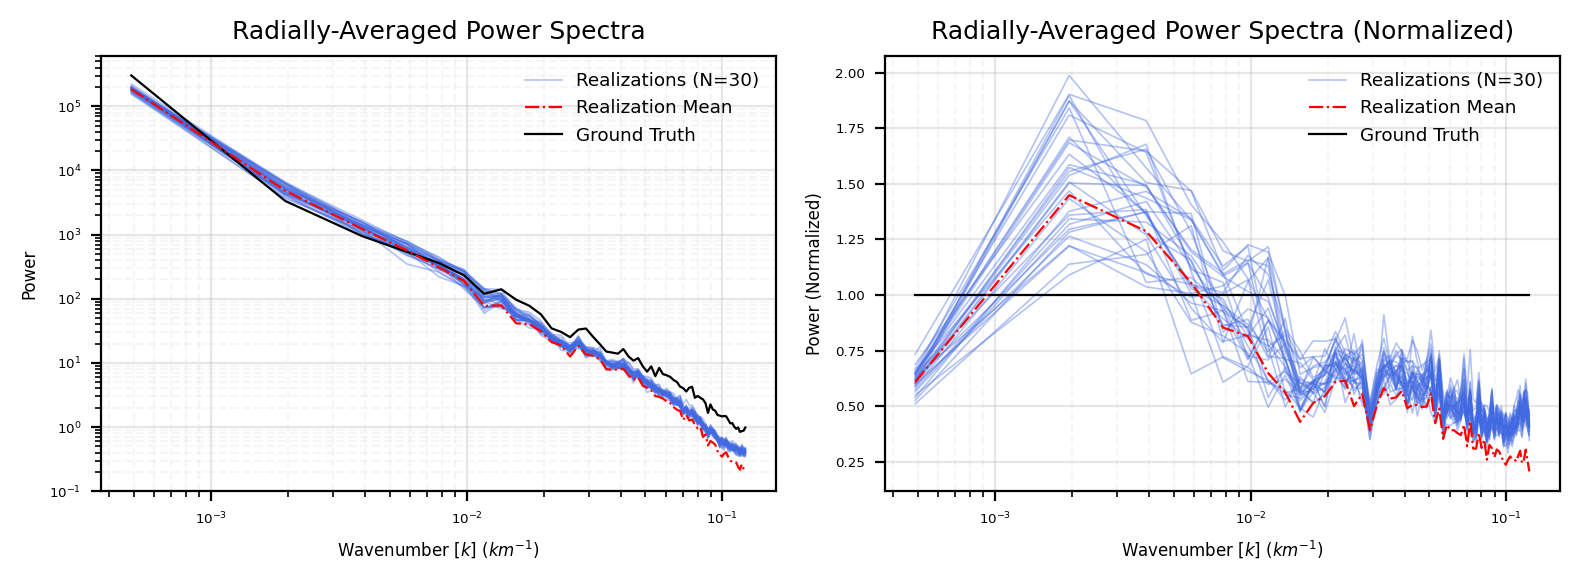

In [234]:
# ====================
# Plot spectra
# ====================
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8.,3.), dpi=200)

# Figure constants
ts = 6
tick_fs = 8*0.6
colors = ["royalblue"]*N + ["red", 'k']
alphas = [0.4]*N + [1.0, 1.0]
styles = ['-']*N + ['-.', '-']
lws = [.6]*N + [.8, 0.8]
priority = [4]*N + [6, 5]

# compute the spectra
fields = realizations + [realization_mean, ground_truth]
spectra = []
for field in fields:
    power, bin_midpts, bin_counts = rapsd(field, 4.0)
    spectra.append([power, bin_midpts, bin_counts])

# plot
ax[0].set_title("Radially-Averaged Power Spectra", fontsize=ts*1.5)
ax[0].set_xlabel("Wavenumber $[k]$ ($km^{-1}$)", fontsize=ts)
ax[0].set_ylabel("Power", fontsize=ts)
ax[0].grid(alpha=.3, which='major', ls='-')
ax[0].grid(alpha=.1, which='minor', ls='--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].tick_params(axis='both', labelsize=tick_fs)
field_names = [f"Realizations (N={N})"] + [None for i in range(N-1)] + ["Realization Mean", "Ground Truth"]
for i, (spectrum, bin_midpts, bin_counts) in enumerate(spectra):
    ax[0].plot(bin_midpts.numpy(), spectrum.numpy(), label=field_names[i], color=colors[i], linestyle=styles[i], lw=lws[i], alpha=alphas[i], zorder=priority[i])
ax[0].legend(fontsize=ts*1.1, frameon=False)

ax[1].set_title("Radially-Averaged Power Spectra (Normalized)", fontsize=ts*1.5)
ax[1].set_xlabel("Wavenumber $[k]$ ($km^{-1}$)", fontsize=ts)
ax[1].set_ylabel("Power (Normalized)", fontsize=ts)
ax[1].grid(alpha=.3, which='major', ls='-')
ax[1].grid(alpha=.1, which='minor', ls='--')
ax[1].set_xscale('log')
ax[1].tick_params(axis='both', labelsize=tick_fs)
field_names = [f"Realizations (N={N})"] + [None for i in range(N-1)] + ["Realization Mean", "Ground Truth"]
for i, (spectrum, bin_midpts, bin_counts) in enumerate(spectra):
    ax[1].plot(bin_midpts.numpy(), spectrum.numpy()/spectra[-1][0].numpy(), label=field_names[i], color=colors[i], linestyle=styles[i], lw=lws[i], alpha=alphas[i], zorder=priority[i])
ax[1].legend(fontsize=ts*1.1, frameon=False)

plt.tight_layout()
plt.show()

# Ensembles Time Series

Number of timesteps: 1488 
Number of ensembles: 10


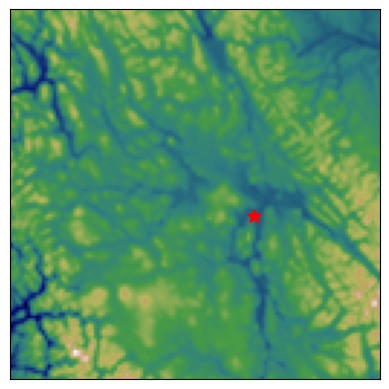

In [4]:
x,y = 84,56
number_of_ensembles = 10
number_of_timesteps = (i2 - i1)//2 + 12
i0 = 1464
print("Number of timesteps:", number_of_timesteps, "\nNumber of ensembles:", number_of_ensembles)
if not number_of_timesteps % 24 == 0:
    print(f"{number_of_timesteps} is not an integer multiple of 24. This will cause problems later.")
fwi_ds_ensemble_timeseries = np.zeros((number_of_ensembles, number_of_timesteps))
fwi_gt_timeseries = np.zeros((number_of_timesteps))
plt.imshow(topography_hr.squeeze().squeeze(),cmap='gist_earth',origin='lower')
plt.plot(x,y,'*',color='red',markersize=10)
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
datetime_list = []
for i in range(number_of_timesteps):  
    datetime = fwifiles_hr[i+i0][-16:-6] + " " + fwifiles_hr[i+i0][-5:-3] + "00"
    datetime_list.append(datetime)
    print(datetime, f"({i+1}/{number_of_timesteps} or {100*(i+1)/number_of_timesteps:.2f}%)")
    # Low resolution input (to be downscaled)
    tas_i = tas_lr[i+i0].unsqueeze(0).unsqueeze(0)
    uas_i = uas_lr[i+i0].unsqueeze(0).unsqueeze(0)
    vas_i = vas_lr[i+i0].unsqueeze(0).unsqueeze(0)
    ps_i = ps_lr[i+i0].unsqueeze(0).unsqueeze(0)
    r2_i = r2_lr[i+i0].unsqueeze(0).unsqueeze(0)
    pr_i = pr_lr[i+i0].unsqueeze(0).unsqueeze(0)
    bui_i = bui_lr[i+i0].unsqueeze(0).unsqueeze(0)
    fwi_i = fwi_lr[i+i0].unsqueeze(0).unsqueeze(0)
    input_lr = torch.cat([tas_i,uas_i,vas_i,ps_i,r2_i,pr_i,fwi_i,topography_lr],dim=1).float().cuda()
    input_hr = topography_hr.cuda()

    # High resolution (truth)
    fwi_i_hr = fwi_hr[i+i0]
    fwi_gt_timeseries[i] = fwi_i_hr[y,x]*(FWI_hr_max-FWI_hr_min) + FWI_hr_min

    # plug into model for downscaling
    for e in range(number_of_ensembles):
        fwi_i_downscaled = model(input_lr, input_hr)[0,0,y,x]
        fwi_i_downscaled = fwi_i_downscaled.squeeze().cpu().detach().numpy()*(FWI_hr_max-FWI_hr_min) + FWI_hr_min
        # fwi_i_downscaled[fwi_i_downscaled < 0] = np.nan
        fwi_ds_ensemble_timeseries[e,i] = fwi_i_downscaled



2004-07-01 0000 (1/1488 or 0.07%)
2004-07-01 0100 (2/1488 or 0.13%)
2004-07-01 0200 (3/1488 or 0.20%)
2004-07-01 0300 (4/1488 or 0.27%)
2004-07-01 0400 (5/1488 or 0.34%)
2004-07-01 0500 (6/1488 or 0.40%)
2004-07-01 0600 (7/1488 or 0.47%)
2004-07-01 0700 (8/1488 or 0.54%)
2004-07-01 0800 (9/1488 or 0.60%)
2004-07-01 0900 (10/1488 or 0.67%)
2004-07-01 1000 (11/1488 or 0.74%)
2004-07-01 1100 (12/1488 or 0.81%)
2004-07-01 1200 (13/1488 or 0.87%)
2004-07-01 1300 (14/1488 or 0.94%)
2004-07-01 1400 (15/1488 or 1.01%)
2004-07-01 1500 (16/1488 or 1.08%)
2004-07-01 1600 (17/1488 or 1.14%)
2004-07-01 1700 (18/1488 or 1.21%)
2004-07-01 1800 (19/1488 or 1.28%)
2004-07-01 1900 (20/1488 or 1.34%)
2004-07-01 2000 (21/1488 or 1.41%)
2004-07-01 2100 (22/1488 or 1.48%)
2004-07-01 2200 (23/1488 or 1.55%)
2004-07-01 2300 (24/1488 or 1.61%)
2004-07-02 0000 (25/1488 or 1.68%)
2004-07-02 0100 (26/1488 or 1.75%)
2004-07-02 0200 (27/1488 or 1.81%)
2004-07-02 0300 (28/1488 or 1.88%)
2004-07-02 0400 (29/1488 or 1

In [7]:
# Create an xarray dataset
# fwi_ds_ensemble_dataset_xr = xr.Dataset(
#     {
#         "fwi": (["ensemble", "time"], fwi_ds_ensemble_timeseries)
#     },
#     coords={
#         "ensemble": np.arange(number_of_ensembles),
#         "time": datetime_list
#     }
# )

# fwi_ds_ensemble_dataset_xr.to_netcdf(f'/users/rpayne/data/FWI/ensembles/fwi_30ensemble_2mt_x{x}y{y}cint.nc')
# fwi_ds_ensemble_timeseries = xr.open_dataset(f'/users/rpayne/data/FWI/ensembles/fwi_30ensemble_2mt_x{84}y{16}cint.nc')['fwi'].to_numpy()

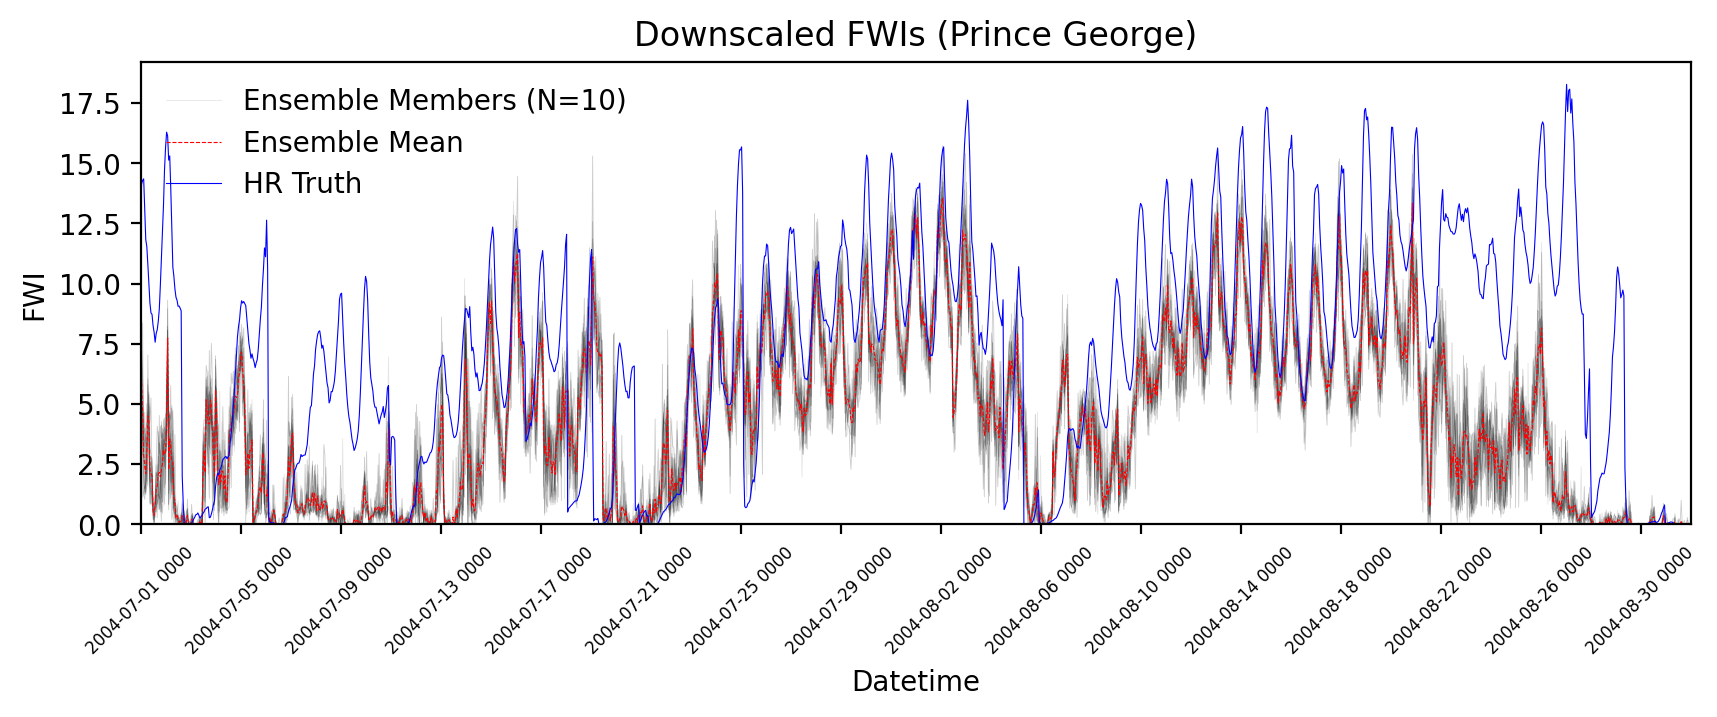

Correlation between Ensemble Mean and HR Truth: 0.6453374677579555
MAE between Ensemble Mean and HR Truth: 3.539593084529892


In [8]:
plt.figure(figsize=(10,3), dpi=200)
for e in range(number_of_ensembles):
    if e == 0:
        plt.plot(fwi_ds_ensemble_timeseries[e,:], label=f'Ensemble Members (N={number_of_ensembles})', linewidth=.3, color='black', alpha=.1)
    else:
        plt.plot(fwi_ds_ensemble_timeseries[e,:], linewidth=.3, color='black', alpha=.2)
plt.plot(fwi_ds_ensemble_timeseries.mean(axis=0)[:], label='Ensemble Mean', color='red', linewidth=.4, ls='--')
plt.plot(fwi_gt_timeseries, label='HR Truth', color='blue', linewidth=.4)
plt.title(f"Downscaled FWIs (Prince George)")
plt.xlabel("Datetime")
plt.ylabel("FWI")
plt.xlim(left=0, right=number_of_timesteps)
plt.ylim(bottom=0)
plt.xticks(np.arange(0,len(datetime_list),96),labels=datetime_list[::96], rotation=45, fontsize=6)
plt.legend(fontsize=10, frameon=False, loc='upper left')
plt.show()

print("Correlation between Ensemble Mean and HR Truth:", 
    np.corrcoef(fwi_ds_ensemble_timeseries.mean(axis=0),
    fwi_gt_timeseries)[0,1])
print("MAE between Ensemble Mean and HR Truth:",
    np.mean(np.abs(fwi_ds_ensemble_timeseries.mean(axis=0) - fwi_gt_timeseries)))

In [9]:
fwi_ds_ensemble_timeseries_dailymax = fwi_ds_ensemble_timeseries.reshape(number_of_ensembles,-1,24).max(axis=2)
fwi_ds_ensemble_timeseries_dailymax_mean = fwi_ds_ensemble_timeseries.reshape(number_of_ensembles,-1,24).max(axis=2).mean(axis=0)
fwi_gt_timeseries_dailymax = fwi_gt_timeseries.reshape(-1, 24).max(axis=1)

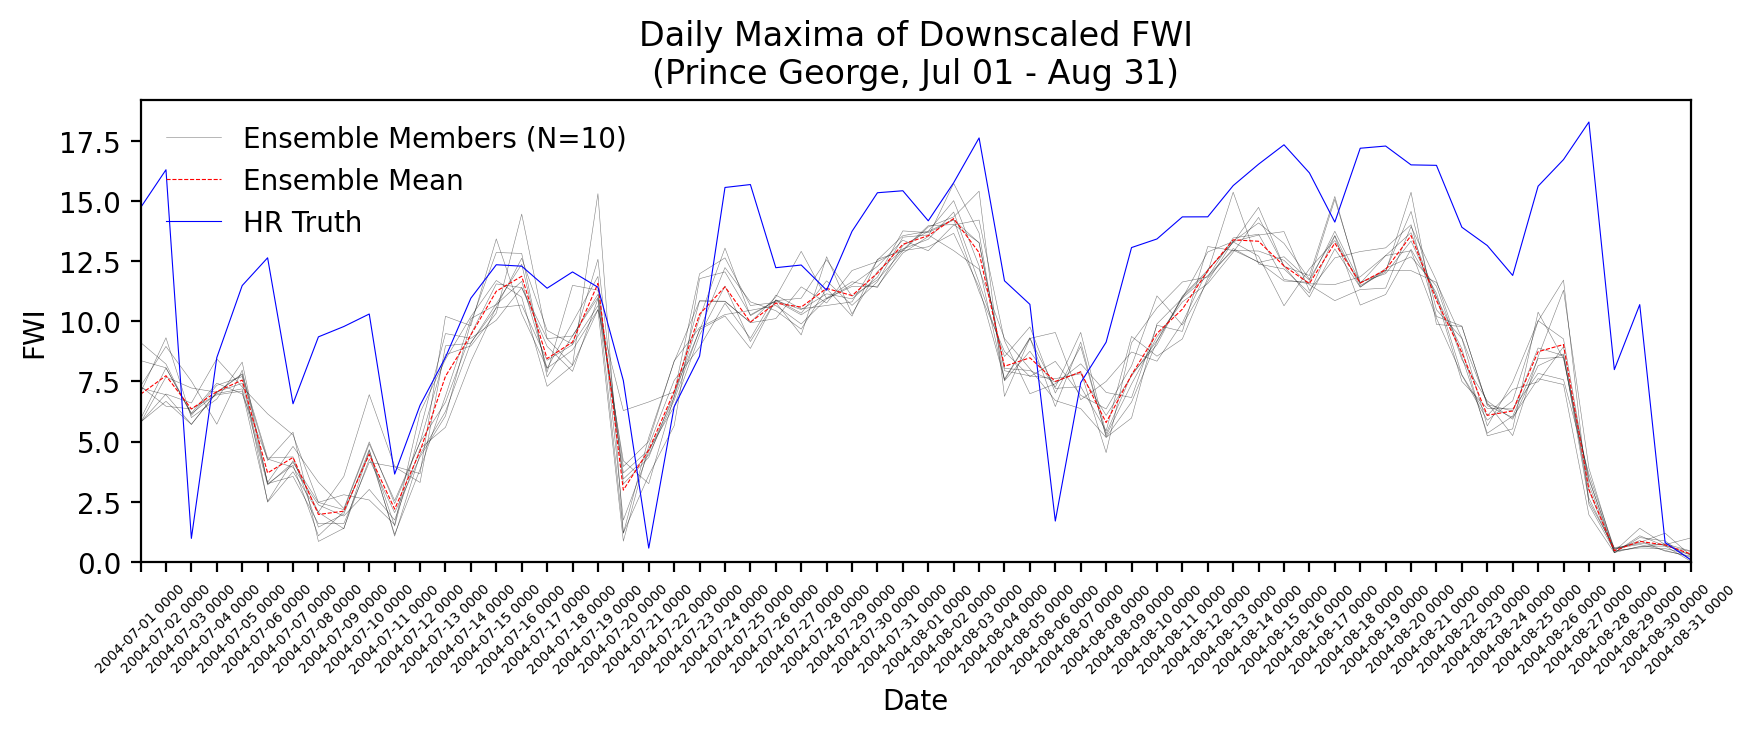

Correlation between Ensemble Mean and HR Truth: 0.6531392081824412
MAE between Ensemble Mean and HR Truth: 3.914967934065463


In [10]:
plt.figure(figsize=(10,3), dpi=200)
for e in range(number_of_ensembles):
    if e == 0:
        plt.plot(fwi_ds_ensemble_timeseries_dailymax[e], label=f'Ensemble Members (N={number_of_ensembles})', linewidth=.2, color='black', alpha=.5)
    else:
        plt.plot(fwi_ds_ensemble_timeseries_dailymax[e], linewidth=.2, color='black', alpha=.5)
plt.plot(fwi_ds_ensemble_timeseries_dailymax_mean , label='Ensemble Mean', color='red', linewidth=.4,ls='--')
plt.plot(fwi_gt_timeseries_dailymax, label='HR Truth', color='blue', linewidth=.4)
plt.title(f"Daily Maxima of Downscaled FWI\n(Prince George, Jul 01 - Aug 31)")
plt.xlabel("Date")
plt.ylabel("FWI")
plt.xlim(left=0, right=31+30)
plt.ylim(bottom=0)
# for ii in range(len(datetime_list)):
#     datetime_list[ii] = datetime_list[ii][:-4]
plt.xticks(np.arange(0,len(datetime_list)//24),labels=datetime_list[::24], rotation=45, fontsize=5)
plt.legend(fontsize=10, frameon=False, loc='upper left')
plt.show()

print("Correlation between Ensemble Mean and HR Truth:", 
    np.corrcoef(fwi_ds_ensemble_timeseries_dailymax_mean ,
    fwi_gt_timeseries_dailymax)[0,1])
print("MAE between Ensemble Mean and HR Truth:",
    np.mean(np.abs(fwi_ds_ensemble_timeseries_dailymax_mean - fwi_gt_timeseries_dailymax)))

In [87]:
# rank histogram
def compute_rank(truth, ensemble):
    """
    Compute the rank of a value in an array.
    """
    if isinstance(ensemble, list):
        ensemble = np.array(ensemble)
    return np.sum(truth > ensemble) + 1

NameError: name 'ranks' is not defined

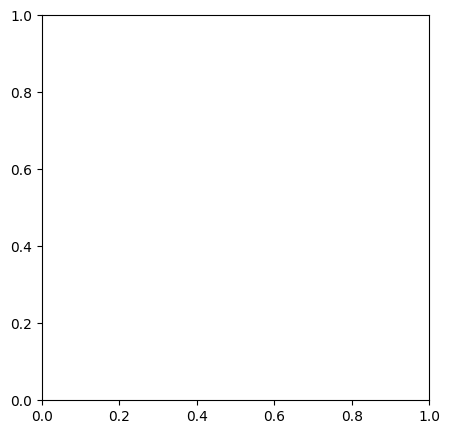

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)
ax.hist(ranks/max(ranks), bins=np.linspace(0,1,21), color='navy', alpha=.5, rwidth=.9)
ax.set_xlabel("Normalized Rank", fontsize=8)
ax.set_title("Rank Histogram")
ax.set_yticks(np.arange(0,20,2))
plt.show()

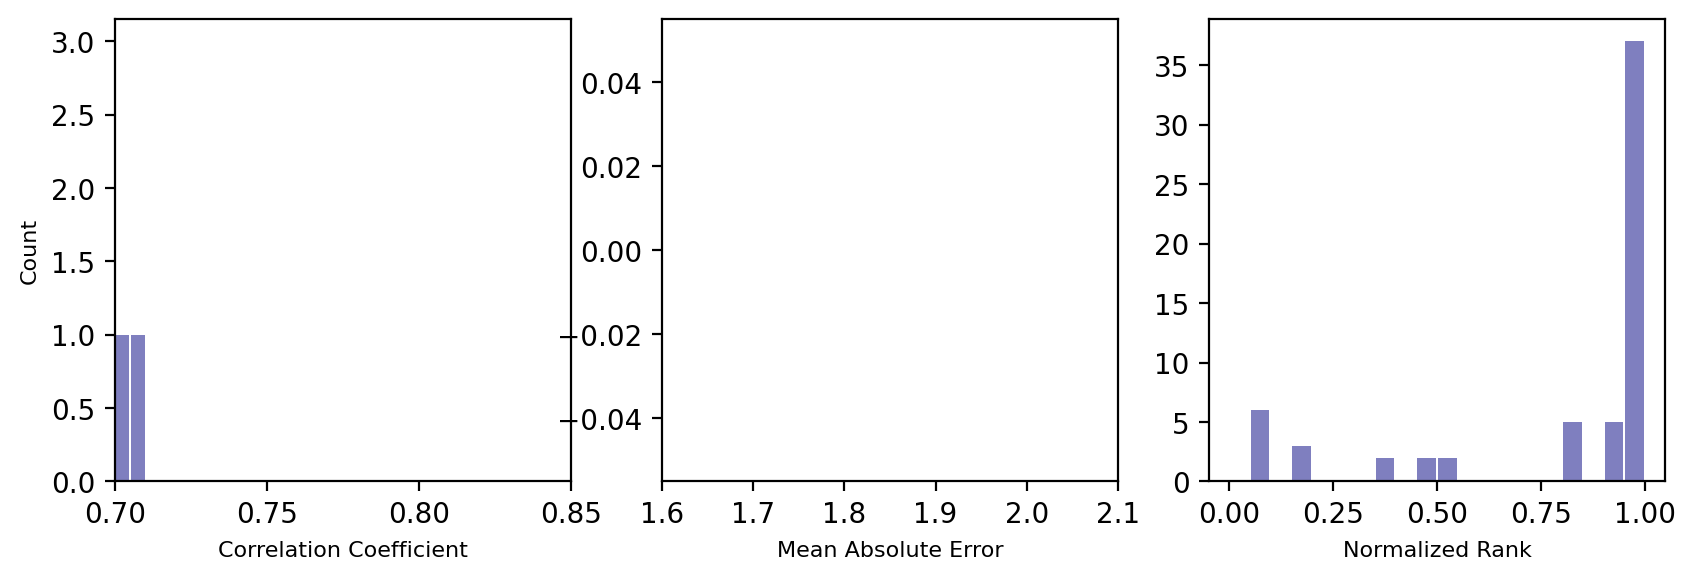

In [89]:
correlations = []
MAE = []
for e in range(number_of_ensembles):
    correlations.append(np.corrcoef(fwi_ds_ensemble_timeseries_dailymax[e],fwi_gt_timeseries_dailymax)[0,1])
    MAE.append(np.abs(fwi_ds_ensemble_timeseries_dailymax[e] - fwi_gt_timeseries_dailymax).mean())

ranks = []
for ti in range(len(fwi_gt_timeseries_dailymax)):
    ranks.append(compute_rank(fwi_gt_timeseries_dailymax[ti], fwi_ds_ensemble_timeseries_dailymax.transpose()[ti,:]))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), dpi=200)
ax[0].hist(correlations, color='navy', alpha=.5, bins=np.arange(0,1+.005,.005), rwidth=.9)
ax[0].axvline(np.mean(correlations), color='red', linestyle='--', linewidth=.5)
ax[0].set_xlim(left=0.7, right=.85)
ax[0].set_xlabel("Correlation Coefficient", fontsize=8)
ax[0].set_ylabel("Count", fontsize=8)

ax[1].hist(MAE, color='navy', alpha=.5, bins=np.arange(1.5,2.1+.02,.02), rwidth=.9)
ax[1].axvline(np.mean(MAE), color='red', linestyle='--', linewidth=.5)
ax[1].set_xlim(left=1.6, right=2.1)
ax[1].set_xlabel("Mean Absolute Error", fontsize=8)
# ax[1].set_ylabel("Count", fontsize=8)

ax[2].hist(ranks/max(ranks), bins=np.linspace(0,1,21), color='navy', alpha=.5, rwidth=.9)
ax[2].set_xlabel("Normalized Rank", fontsize=8)
# ax[2].set_ylabel("Count", fontsize=8)

plt.show()

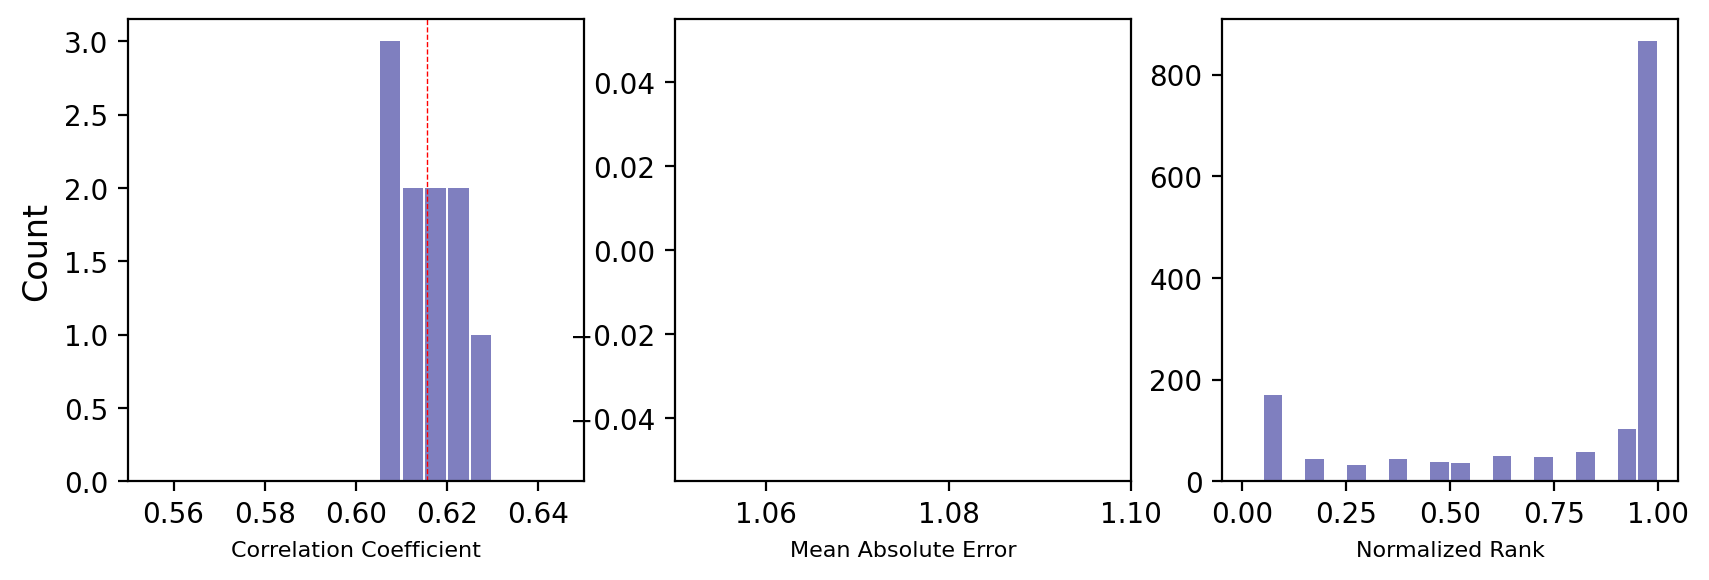

In [90]:
correlations = []
MAE = []
for e in range(number_of_ensembles):
    correlations.append(np.corrcoef(fwi_ds_ensemble_timeseries[e],fwi_gt_timeseries)[0,1])
    MAE.append(np.abs(fwi_ds_ensemble_timeseries[e] - fwi_gt_timeseries).mean())

ranks = []
for ti in range(len(fwi_gt_timeseries)):
    ranks.append(compute_rank(fwi_gt_timeseries[ti], fwi_ds_ensemble_timeseries.transpose()[ti,:]))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), dpi=200)
ax[0].hist(correlations, color='navy', alpha=.5, bins=np.arange(0,1+.005,.005), rwidth=.9)
ax[0].axvline(np.mean(correlations), color='red', linestyle='--', linewidth=.5)
ax[0].set_xlim(left=0.55, right=.65)
ax[0].set_xlabel("Correlation Coefficient", fontsize=8)
ax[0].set_ylabel("Count", fontsize=12)

ax[1].hist(MAE, color='navy', alpha=.5, bins=np.linspace(1.05,1.1, 20), rwidth=.9)
ax[1].axvline(np.mean(MAE), color='red', linestyle='--', linewidth=.5)
ax[1].set_xlim(left=1.05, right=1.1)
ax[1].set_xlabel("Mean Absolute Error", fontsize=8)
# ax[1].set_yticks(np.arange(0, 6, 1))
# ax[1].set_yticklabels(np.arange(0, 6, 1), fontsize=6)

ax[2].hist(ranks/max(ranks), bins=np.linspace(0,1,21), color='navy', alpha=.5, rwidth=.9)
ax[2].set_xlabel("Normalized Rank", fontsize=8)
# ax[2].set_ylabel("Count", fontsize=8)
# ax[2].set_yticks(np.arange(0, 1200, 200))
# ax[2].set_yticklabels(np.arange(0, 1200, 200), fontsize=6)

plt.show()

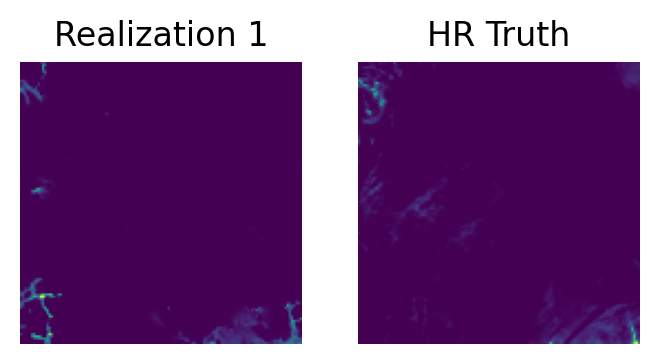

In [26]:
# Generate 4 realizations and plot them
# i = rand.randint(0, Nfiles-1)
i = Nfiles-1
datetime = fwifiles_hr[i][-16:-6] + " " + fwifiles_hr[i][-5:-3] + "00"

tas_i = tas_lr[i].unsqueeze(0).unsqueeze(0)
uas_i = uas_lr[i].unsqueeze(0).unsqueeze(0)
vas_i = vas_lr[i].unsqueeze(0).unsqueeze(0)
ps_i = ps_lr[i].unsqueeze(0).unsqueeze(0)
r2_i = r2_lr[i].unsqueeze(0).unsqueeze(0)
pr_i = pr_lr[i].unsqueeze(0).unsqueeze(0)
bui_i = bui_lr[i].unsqueeze(0).unsqueeze(0)
input_lr = torch.cat([tas_i,uas_i,vas_i,ps_i,r2_i,pr_i,bui_i,topography_lr],dim=1).float().cuda()
input_hr = topography_hr.cuda()

tas_i_hr = tas_hr[i]
uas_i_hr = uas_hr[i]
vas_i_hr = vas_hr[i]
ps_i_hr = ps_hr[i]
r2_i_hr = r2_hr[i]
pr_i_hr = pr_hr[i]
fwi_i_hr = fwi_hr[i]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4,4), dpi=200)

N = 4
ts = 8

# plug into model for downscaling
downscaled_fields = model(input_lr, input_hr)
fwi_i_downscaled = downscaled_fields[0,0,:,:]
fwi_i_downscaled = fwi_i_downscaled.squeeze().cpu().detach().numpy()*(FWI_hr_max-FWI_hr_min) + FWI_hr_min
# fwi_i_downscaled[fwi_i_downscaled < .01] = np.nan

ax[0].imshow(fwi_i_downscaled,cmap='viridis',origin='lower',vmin=0)
ax[0].set_title(f"Realization {0+1}")
ax[0].axis('off')

fwi_i_hr_np = np.array(fwi_i_hr)*(FWI_hr_max-FWI_hr_min) + FWI_hr_min
# fwi_i_hr_np[fwi_i_hr_np == 0] = np.nan

refplot = ax[1].imshow(fwi_i_hr_np.squeeze(),cmap='viridis',origin='lower')
ax[1].set_title("HR Truth")
ax[1].axis('off')

# (11,3) for bottom right, (11,30) for top right
# ax[0].text(0, -5, f'{datetime[:10]} at {datetime[11:]} (idx {i})', fontsize=.8*ts, color='red', verticalalignment='top', horizontalalignment='left')

# Add colorbar (using the last plotted image for the colorbar)
# colorbar = fig.colorbar(refplot, ax=ax, orientation='horizontal', pad=0.05, aspect=140)
# colorbar.outline.set_visible(False)
# colorbar.ax.tick_params(labelsize=5, width=.25)
# colorbar.ax.set_title(r"FWI",fontsize=ts, pad=-4)
# fig.subplots_adjust(right=0.85,)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
# colorbar = fig.colorbar(refplot, cax=cbar_ax, aspect=40)
# colorbar.outline.set_visible(False)
# colorbar.ax.tick_params(labelsize=5, width=.25)
# colorbar.ax.set_title(r"FWI", fontsize=ts, pad=-4)

plt.show()